In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('openaqi_final.csv')

In [3]:
df.head()

,loc_id,location_name,latitude,longitude,parameter_o3,parameter_no2,parameter_pm10,parameter_so2,date
0,Loc_1,Barcelona,41.38749,2.1152,21.386792,9.952830,0.433962,0.877358,30-09-2023
1,Loc_1,Barcelona,41.38749,2.1152,10.380000,11.190000,0.440000,0.580000,01-10-2023
2,Loc_1,Barcelona,41.38749,2.1152,14.685484,12.879032,0.306452,0.629032,02-10-2023
3,Loc_1,Barcelona,41.38749,2.1152,12.275229,11.577982,0.211009,0.550459,03-10-2023
4,Loc_1,Barcelona,41.38749,2.1152,9.093220,13.296610,0.211864,0.576271,04-10-2023


In [4]:
# print unique values in the 'location' column
print(df['location_name'].unique())

['Barcelona' "BARCELONA (PARC DE LA VALL D'HEBRON)" 'Montcada i Reixac'
 'Rubí' 'TERRASSA (PARE ALEGRE)'
 'VILANOVA I LA GELTRÚ (PL. DE LES DANSES DE VILANOVA)']


In [5]:
longitudes = df['longitude'].unique()

In [6]:
latitudes = df['latitude'].unique()

In [7]:
print(longitudes)
print(latitudes)

[2.1151996  2.1537998  2.1533988  2.14799203 2.1882975  2.0424972
 2.00740127 1.72124877]
[41.38749    41.385315   41.398724   41.4260772  41.48197    41.492115
 41.5561154  41.21903646]


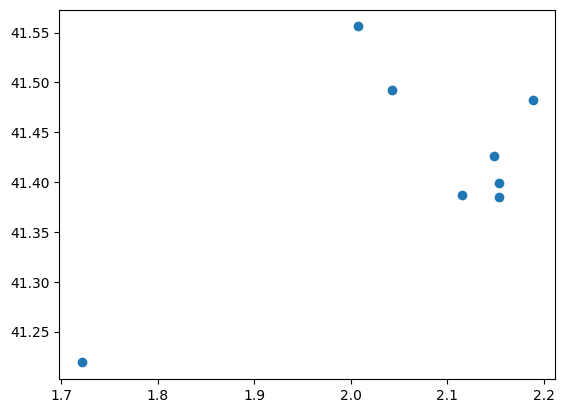

In [8]:
# plot locations on a map
import matplotlib.pyplot as plt

plt.scatter(longitudes, latitudes)
plt.show()


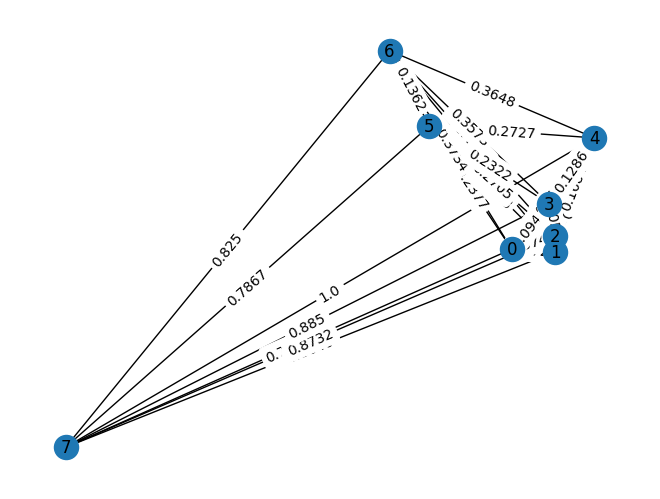

In [12]:
#create a connected graph of locations
import networkx as nx

G = nx.Graph()

for i in range(len(longitudes)):
    G.add_node(i, pos=(longitudes[i], latitudes[i]))
    
for i in range(len(longitudes)):
    for j in range(i+1, len(longitudes)):
        G.add_edge(i, j, weight=np.sqrt((longitudes[i]-longitudes[j])**2 + (latitudes[i]-latitudes[j])**2)) 
#normalizing the edge weights
weights = nx.get_edge_attributes(G, 'weight')
max_weight = max(weights.values())
min_weight = min(weights.values())
for edge in weights:
    weights[edge] = (weights[edge])/(max_weight)
    #rounding to 2 decimal places
    weights[edge] = round(weights[edge], 4)
nx.set_edge_attributes(G, weights, 'weight')

        
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


In [14]:
print(weights)

{(0, 1): 0.05, (0, 2): 0.05, (0, 3): 0.07, (0, 4): 0.2, (0, 5): 0.22, (0, 6): 0.36, (0, 7): 0.79, (1, 2): 0.0, (1, 3): 0.05, (1, 4): 0.17, (1, 5): 0.27, (1, 6): 0.4, (1, 7): 0.86, (2, 3): 0.03, (2, 4): 0.15, (2, 5): 0.25, (2, 6): 0.39, (2, 7): 0.87, (3, 4): 0.11, (3, 5): 0.21, (3, 6): 0.34, (3, 7): 0.88, (4, 5): 0.25, (4, 6): 0.35, (4, 7): 1.0, (5, 6): 0.11, (5, 7): 0.78, (6, 7): 0.82}


In [18]:
#implementing gnn to predict air quality from scratch
#using the graph created above
#using the openaqi dataset
#coloumns includes parameter_o3,parameter_no2parameter_pm10,parameter_so2
#target column is parameter_pm10

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

#creating a graph data object
data = from_networkx(G)
print(data)



Data(edge_index=[2, 56], pos=[8, 2], weight=[56])


In [19]:
#creating a simple graph neural network
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 1)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x
    

In [20]:
#creating a model
model = GCN()
print(model)


GCN(
  (conv1): GCNConv(0, 16)
  (conv2): GCNConv(16, 1)
)


In [21]:
#creating a loss function
criterion = nn.MSELoss()

#creating an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

#training the model
model.train()

GCN(
  (conv1): GCNConv(0, 16)
  (conv2): GCNConv(16, 1)
)

In [22]:
#creating a tensor for the target column
target = torch.tensor(df['parameter_pm10'].values, dtype=torch.float32)

for epoch in range(100):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, target)
    loss.backward()
    optimizer.step()
    print(loss.item())

AttributeError: 'NoneType' object has no attribute 'size'

In [24]:
df.head()


,loc_id,location_name,latitude,longitude,parameter_no2,parameter_o3,parameter_pm10,parameter_so2,date
0,Loc_1,Barcelona,41.38749,2.1152,21.386792,9.952830,0.433962,0.877358,30-09-2023
1,Loc_1,Barcelona,41.38749,2.1152,10.380000,11.190000,0.440000,0.580000,01-10-2023
2,Loc_1,Barcelona,41.38749,2.1152,14.685484,12.879032,0.306452,0.629032,02-10-2023
3,Loc_1,Barcelona,41.38749,2.1152,12.275229,11.577982,0.211009,0.550459,03-10-2023
4,Loc_1,Barcelona,41.38749,2.1152,9.093220,13.296610,0.211864,0.576271,04-10-2023


In [26]:
#create a dataset from df containing the columns with unique data for loc_id, location_name, longitude, latitude 

df2 = df[['loc_id', 'location_name', 'longitude', 'latitude']].drop_duplicates()
df2.head()

,loc_id,location_name,longitude,latitude
0,Loc_1,Barcelona,2.115200,41.387490
297,Loc_2,Barcelona,2.153800,41.385315
622,Loc_3,Barcelona,2.153399,41.398724
940,Loc_4,BARCELONA (PARC DE LA VALL D'HEBRON),2.147992,41.426077
999,Loc_5,Montcada i Reixac,2.188298,41.481970


In [27]:
#save df2 to a csv file
df2.to_csv('locations.csv', index=False)
df.head()

In [5]:
df.head()
df 

,loc_id,location_name,latitude,longitude,Unnamed: 4,parameter_o3,parameter_no2parameter_pm10,parameter_so2,date
0,Loc_1,Barcelona,41.38749,2.1152,21.386792,9.952830,0.433962,0.877358,30-09-2023
1,Loc_1,Barcelona,41.38749,2.1152,10.380000,11.190000,0.440000,0.580000,01-10-2023
2,Loc_1,Barcelona,41.38749,2.1152,14.685484,12.879032,0.306452,0.629032,02-10-2023
3,Loc_1,Barcelona,41.38749,2.1152,12.275229,11.577982,0.211009,0.550459,03-10-2023
4,Loc_1,Barcelona,41.38749,2.1152,9.093220,13.296610,0.211864,0.576271,04-10-2023


In [13]:
#create a dataset havig rows conatining having first column as date , other columns cityname_pm10, cityname_o3, cityname_no2, cityname_so2 for each city on that date
#where cityname is the name of the city and pm10, o3, no2, so2 are the values of the respective parameters on that date
#there are 8 cities in the dataset so 8X4 = 32 columns + date column = 33 columns in the dataset
#save this dataset to a csv file

df3 = df[['date','loc_id', 'location_name', 'parameter_pm10', 'parameter_o3', 'parameter_no2', 'parameter_so2']]
df3.drop_duplicates(inplace=True)
df3 = df3.pivot(index='date', columns='loc_id')
df3.columns = ['_'.join(col).strip() for col in df3.columns.values]
df3.reset_index(inplace=True)
df3.head()



C:\Users\rhyth\AppData\Local\Temp\ipykernel_13508\4033629640.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.drop_duplicates(inplace=True)


,date,location_name_Loc_1,location_name_Loc_2,location_name_Loc_3,location_name_Loc_4,location_name_Loc_5,location_name_Loc_6,location_name_Loc_7,location_name_Loc_8,parameter_pm10_Loc_1,...,parameter_no2_Loc_7,parameter_no2_Loc_8,parameter_so2_Loc_1,parameter_so2_Loc_2,parameter_so2_Loc_3,parameter_so2_Loc_4,parameter_so2_Loc_5,parameter_so2_Loc_6,parameter_so2_Loc_7,parameter_so2_Loc_8
0,01-01-2024,Barcelona,Barcelona,Barcelona,NaN,Montcada i Reixac,NaN,TERRASSA (PARE ALEGRE),VILANOVA I LA GELTRÚ (PL. DE LES DANSES DE VIL...,5.333333,...,6.000000,6.000000,0.121254,0.121254,0.121254,NaN,0.121254,NaN,0.121254,0.121254
1,01-03-2024,Barcelona,Barcelona,Barcelona,NaN,Montcada i Reixac,NaN,TERRASSA (PARE ALEGRE),VILANOVA I LA GELTRÚ (PL. DE LES DANSES DE VIL...,1.333333,...,42.666667,42.666667,0.121254,0.121254,0.121254,NaN,0.121254,NaN,0.121254,0.121254
2,01-04-2024,Barcelona,Barcelona,Barcelona,NaN,Montcada i Reixac,NaN,TERRASSA (PARE ALEGRE),VILANOVA I LA GELTRÚ (PL. DE LES DANSES DE VIL...,0.333333,...,42.666667,42.666667,0.121254,0.121254,0.121254,NaN,0.121254,NaN,0.121254,0.121254
3,01-05-2024,Barcelona,Barcelona,NaN,NaN,Montcada i Reixac,NaN,TERRASSA (PARE ALEGRE),VILANOVA I LA GELTRÚ (PL. DE LES DANSES DE VIL...,1.500000,...,12.000000,12.000000,0.121254,0.121254,NaN,NaN,0.121254,NaN,0.121254,0.121254
4,01-06-2024,NaN,NaN,Barcelona,NaN,Montcada i Reixac,NaN,TERRASSA (PARE ALEGRE),VILANOVA I LA GELTRÚ (PL. DE LES DANSES DE VIL...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df3.shape   

(361, 41)

In [15]:
df3.to_csv('city_data.csv', index=False)

In [16]:
df3.head()

,date,location_name_Loc_1,location_name_Loc_2,location_name_Loc_3,location_name_Loc_4,location_name_Loc_5,location_name_Loc_6,location_name_Loc_7,location_name_Loc_8,parameter_pm10_Loc_1,...,parameter_no2_Loc_7,parameter_no2_Loc_8,parameter_so2_Loc_1,parameter_so2_Loc_2,parameter_so2_Loc_3,parameter_so2_Loc_4,parameter_so2_Loc_5,parameter_so2_Loc_6,parameter_so2_Loc_7,parameter_so2_Loc_8
0,01-01-2024,Barcelona,Barcelona,Barcelona,NaN,Montcada i Reixac,NaN,TERRASSA (PARE ALEGRE),VILANOVA I LA GELTRÚ (PL. DE LES DANSES DE VIL...,5.333333,...,6.000000,6.000000,0.121254,0.121254,0.121254,NaN,0.121254,NaN,0.121254,0.121254
1,01-03-2024,Barcelona,Barcelona,Barcelona,NaN,Montcada i Reixac,NaN,TERRASSA (PARE ALEGRE),VILANOVA I LA GELTRÚ (PL. DE LES DANSES DE VIL...,1.333333,...,42.666667,42.666667,0.121254,0.121254,0.121254,NaN,0.121254,NaN,0.121254,0.121254
2,01-04-2024,Barcelona,Barcelona,Barcelona,NaN,Montcada i Reixac,NaN,TERRASSA (PARE ALEGRE),VILANOVA I LA GELTRÚ (PL. DE LES DANSES DE VIL...,0.333333,...,42.666667,42.666667,0.121254,0.121254,0.121254,NaN,0.121254,NaN,0.121254,0.121254
3,01-05-2024,Barcelona,Barcelona,NaN,NaN,Montcada i Reixac,NaN,TERRASSA (PARE ALEGRE),VILANOVA I LA GELTRÚ (PL. DE LES DANSES DE VIL...,1.500000,...,12.000000,12.000000,0.121254,0.121254,NaN,NaN,0.121254,NaN,0.121254,0.121254
4,01-06-2024,NaN,NaN,Barcelona,NaN,Montcada i Reixac,NaN,TERRASSA (PARE ALEGRE),VILANOVA I LA GELTRÚ (PL. DE LES DANSES DE VIL...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# use regression to fill missing data in all the columns of the dataset
# use the columns as features and target column as the column to be filled
# use the filled dataset to train the gnn model

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

df3 = pd.read_csv('city_data.csv')
df3.head()



,date,location_name_Loc_1,location_name_Loc_2,location_name_Loc_3,location_name_Loc_4,location_name_Loc_5,location_name_Loc_6,location_name_Loc_7,location_name_Loc_8,parameter_pm10_Loc_1,...,parameter_no2_Loc_7,parameter_no2_Loc_8,parameter_so2_Loc_1,parameter_so2_Loc_2,parameter_so2_Loc_3,parameter_so2_Loc_4,parameter_so2_Loc_5,parameter_so2_Loc_6,parameter_so2_Loc_7,parameter_so2_Loc_8
0,01-01-2024,Barcelona,Barcelona,Barcelona,NaN,Montcada i Reixac,NaN,TERRASSA (PARE ALEGRE),VILANOVA I LA GELTRÚ (PL. DE LES DANSES DE VIL...,5.333333,...,6.000000,6.000000,0.121254,0.121254,0.121254,NaN,0.121254,NaN,0.121254,0.121254
1,01-03-2024,Barcelona,Barcelona,Barcelona,NaN,Montcada i Reixac,NaN,TERRASSA (PARE ALEGRE),VILANOVA I LA GELTRÚ (PL. DE LES DANSES DE VIL...,1.333333,...,42.666667,42.666667,0.121254,0.121254,0.121254,NaN,0.121254,NaN,0.121254,0.121254
2,01-04-2024,Barcelona,Barcelona,Barcelona,NaN,Montcada i Reixac,NaN,TERRASSA (PARE ALEGRE),VILANOVA I LA GELTRÚ (PL. DE LES DANSES DE VIL...,0.333333,...,42.666667,42.666667,0.121254,0.121254,0.121254,NaN,0.121254,NaN,0.121254,0.121254
3,01-05-2024,Barcelona,Barcelona,NaN,NaN,Montcada i Reixac,NaN,TERRASSA (PARE ALEGRE),VILANOVA I LA GELTRÚ (PL. DE LES DANSES DE VIL...,1.500000,...,12.000000,12.000000,0.121254,0.121254,NaN,NaN,0.121254,NaN,0.121254,0.121254
4,01-06-2024,NaN,NaN,Barcelona,NaN,Montcada i Reixac,NaN,TERRASSA (PARE ALEGRE),VILANOVA I LA GELTRÚ (PL. DE LES DANSES DE VIL...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
#filling missing values
df3.fillna(method='ffill', inplace=True)
df3.fillna(method='bfill', inplace=True)


C:\Users\rhyth\AppData\Local\Temp\ipykernel_13508\2569171076.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df3.fillna(method='ffill', inplace=True)
C:\Users\rhyth\AppData\Local\Temp\ipykernel_13508\2569171076.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df3.fillna(method='bfill', inplace=True)


In [19]:
df.head()

,loc_id,location_name,latitude,longitude,parameter_o3,parameter_no2,parameter_pm10,parameter_so2,date
0,Loc_1,Barcelona,41.38749,2.1152,21.386792,9.952830,0.433962,0.877358,30-09-2023
1,Loc_1,Barcelona,41.38749,2.1152,10.380000,11.190000,0.440000,0.580000,01-10-2023
2,Loc_1,Barcelona,41.38749,2.1152,14.685484,12.879032,0.306452,0.629032,02-10-2023
3,Loc_1,Barcelona,41.38749,2.1152,12.275229,11.577982,0.211009,0.550459,03-10-2023
4,Loc_1,Barcelona,41.38749,2.1152,9.093220,13.296610,0.211864,0.576271,04-10-2023


In [20]:
df3.head()

,date,location_name_Loc_1,location_name_Loc_2,location_name_Loc_3,location_name_Loc_4,location_name_Loc_5,location_name_Loc_6,location_name_Loc_7,location_name_Loc_8,parameter_pm10_Loc_1,...,parameter_no2_Loc_7,parameter_no2_Loc_8,parameter_so2_Loc_1,parameter_so2_Loc_2,parameter_so2_Loc_3,parameter_so2_Loc_4,parameter_so2_Loc_5,parameter_so2_Loc_6,parameter_so2_Loc_7,parameter_so2_Loc_8
0,01-01-2024,Barcelona,Barcelona,Barcelona,BARCELONA (PARC DE LA VALL D'HEBRON),Montcada i Reixac,Rubí,TERRASSA (PARE ALEGRE),VILANOVA I LA GELTRÚ (PL. DE LES DANSES DE VIL...,5.333333,...,6.000000,6.000000,0.121254,0.121254,0.121254,0.58,0.121254,0.58,0.121254,0.121254
1,01-03-2024,Barcelona,Barcelona,Barcelona,BARCELONA (PARC DE LA VALL D'HEBRON),Montcada i Reixac,Rubí,TERRASSA (PARE ALEGRE),VILANOVA I LA GELTRÚ (PL. DE LES DANSES DE VIL...,1.333333,...,42.666667,42.666667,0.121254,0.121254,0.121254,0.58,0.121254,0.58,0.121254,0.121254
2,01-04-2024,Barcelona,Barcelona,Barcelona,BARCELONA (PARC DE LA VALL D'HEBRON),Montcada i Reixac,Rubí,TERRASSA (PARE ALEGRE),VILANOVA I LA GELTRÚ (PL. DE LES DANSES DE VIL...,0.333333,...,42.666667,42.666667,0.121254,0.121254,0.121254,0.58,0.121254,0.58,0.121254,0.121254
3,01-05-2024,Barcelona,Barcelona,Barcelona,BARCELONA (PARC DE LA VALL D'HEBRON),Montcada i Reixac,Rubí,TERRASSA (PARE ALEGRE),VILANOVA I LA GELTRÚ (PL. DE LES DANSES DE VIL...,1.500000,...,12.000000,12.000000,0.121254,0.121254,0.121254,0.58,0.121254,0.58,0.121254,0.121254
4,01-06-2024,Barcelona,Barcelona,Barcelona,BARCELONA (PARC DE LA VALL D'HEBRON),Montcada i Reixac,Rubí,TERRASSA (PARE ALEGRE),VILANOVA I LA GELTRÚ (PL. DE LES DANSES DE VIL...,1.500000,...,12.000000,12.000000,0.121254,0.121254,0.121254,0.58,0.121254,0.58,0.121254,0.121254


In [21]:
df3.shape

(361, 41)

In [22]:
#finding the columns with missing values
missing_cols = df3.columns[df3.isnull().any()]
missing_cols


Index([], dtype='object')

In [23]:
#saving the dataset to a csv file
df3.to_csv('city_data_red.csv', index=False)
